- Grad-CAM을 통해 입력 이미지에 대한 모델의 feature map 출력
- feature map을 통해 모델이 이미지의 어떤 부분에 집중하는지 탐색

In [1]:
# 라이브러리 가져오기
import pandas as pd
import matplotlib.pyplot as plt
import os
import glob
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2
import seaborn as sns
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
import matplotlib.cm as cm

# 데이터 로드

In [2]:
# 평가 데이터 클래스 폴더 확인

image_test_data = '/aiffel/aiffel/cv_study/study02/data/test'
test_df = pd.DataFrame(os.listdir(image_test_data ),columns=['test'])
test_df

,test
0,Atopic Dermatitis
1,Warts Molluscum and other Viral Infections
2,Seborrheic Keratoses and other Benign Tumors
3,Melanoma
4,Basal Cell Carcinoma
5,Melanocytic Nevi
6,Tinea Ringworm Candidiasis and other Fungal In...


In [3]:
# 데이터 불러오기 / 훈련 및 평가 나누기

batch_size = 32
target_size = (224,224)

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    image_test_data,
    seed=123,
    shuffle=False,
    image_size=target_size,
    batch_size=batch_size,
)

Found 2139 files belonging to 7 classes.


In [4]:
# 평가데이터 넘파이 형태로 변환

# Convert MapDataset to NumPy arrays
test_data_numpy = test_ds.unbatch().as_numpy_iterator()

# Extract images and labels
x_test, y_test = zip(*test_data_numpy)

# Convert to NumPy arrays
x_test, y_test = np.array(x_test), np.array(y_test)

# shape
print(x_test.shape, y_test.shape)

(2139, 224, 224, 3) (2139,)


# Grad-CAM

In [5]:
model = keras.models.load_model('modelv2.h5')
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
______________________________________________________________________________________________

In [6]:
model.evaluate(x_test, y_test, verbose=1)

67/67 [==============================] - 11s 99ms/step - loss: 0.2069 - accuracy: 0.9388


[0.20688533782958984, 0.9387564063072205]

In [7]:
#신경망 모델의 특 징 추출 부분에서 마지막 층을 지정

#특징 추출 부분만으로 구성된 model_1만들기
last_conv_layer = model.get_layer("conv5_block3_out")
model_1= keras.Model(model.inputs, last_conv_layer.output)

#분류 (전역평균풀링 또는 완전연결층) 부분만으로 구성된 model__2만들기
input_2 = keras.Input(shape=last_conv_layer.output.shape[1:])
x_2 = model.get_layer("global_average_pooling2d")(input_2)
x_2 = model.get_layer("dense")(x_2)
x_2 = model.get_layer("dense_1")(x_2)
model_2=keras.Model(input_2,x_2)

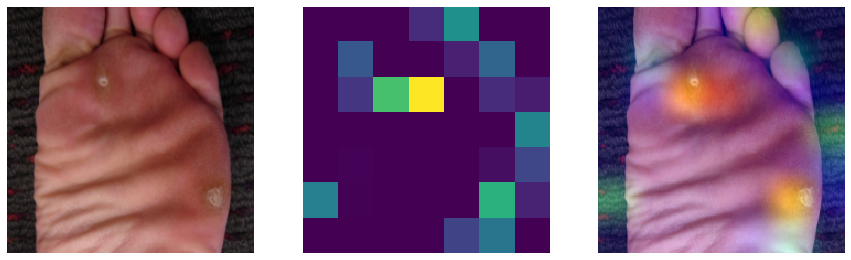

In [34]:
x = x_test[1933]
x = np.expand_dims(x, axis=0)  # 배치 차원 추가

with tf.GradientTape() as tape:
    output_1 = model_1(x)
    tape.watch(output_1) # 마지막 층으로 미분하기 위한 준비
    preds = model_2(output_1)
    class_id = tf.argmax(preds[0])
    output_2 = preds[:,class_id]
 
grads = tape.gradient(output_2, output_1) # 그레디언트 계산
pooled_grads = tf.reduce_mean(grads,axis=(0,1,2)) # 식5 적용
 
output_1 = output_1.numpy()[0]
pooled_grads = pooled_grads.numpy()
for i in range(pooled_grads.shape[-1]):
    output_1[:,:,i]*=pooled_grads[i]
heatmap=np.mean(output_1, axis=-1)
 
heatmap =np.maximum(heatmap, 0)/np.max(heatmap) # 정규화

img = x[0].astype("uint8") # 입력 영상을 다시 받음
 
img=image.img_to_array(img)
heatmap=np.uint8(255*heatmap) # [0,255]로 변환
 
jet = cm.get_cmap("jet") # jet 컬러맵으로 표시
color = jet(np.arange(256))[:,:3]
color_heatmap = color[heatmap]
 
color_heatmap = keras.preprocessing.image.array_to_img(color_heatmap)
color_heatmap = color_heatmap.resize((img.shape[1], img.shape[0]))
color_heatmap = keras.preprocessing.image.img_to_array(color_heatmap)
 
overlay_img= color_heatmap*0.4+img # 덧씌움
overlay_img = keras.preprocessing.image.array_to_img(overlay_img)

fig, axes = plt.subplots(1, 3, figsize=(15, 6)) 

axes[0].imshow(x[0].astype("uint8"))  
axes[0].axis('off')
axes[1].matshow(heatmap)  
axes[1].axis('off')
axes[2].matshow(overlay_img)  
axes[2].axis('off')

plt.show()